Here we want to build a model. We decide on building an LSTM for the following reasons: 
- Need to capture long-term information in the model.
- Other model choices would not be appropriate (due to non-staionary time series).
- Complexity of time series can be properly captured.

We will first build a model for all states, then build a model per state.

In [1]:
import pickle
import polars as pl
import ml_utils
import mlflow
import warnings

warnings.filterwarnings("ignore")

In [2]:
with open('blood_donations.pkl', 'rb') as file:
    df = pickle.load(file)

df.head(10)

date,state,a,b,o,ab,all
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3,87
2006-01-02,"""Johor""",4,3,6,2,15
2006-01-03,"""Johor""",2,2,4,0,8
2006-01-04,"""Johor""",7,11,12,3,33
2006-01-05,"""Johor""",3,8,8,1,20
2006-01-06,"""Johor""",2,0,2,0,4
2006-01-07,"""Johor""",1,0,0,0,1
2006-01-08,"""Johor""",20,27,30,9,86
2006-01-09,"""Johor""",0,1,1,1,3


In [3]:
df = df.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    # pl.col("date").dt.week().alias("week"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df.head(10)

date,state,a,b,o,ab,all,weekday,month,day_of_year
date,str,i64,i64,i64,i64,i64,i8,i8,i16
2006-01-01,"""Johor""",19,20,45,3,87,7,1,1
2006-01-02,"""Johor""",4,3,6,2,15,1,1,2
2006-01-03,"""Johor""",2,2,4,0,8,2,1,3
2006-01-04,"""Johor""",7,11,12,3,33,3,1,4
2006-01-05,"""Johor""",3,8,8,1,20,4,1,5
2006-01-06,"""Johor""",2,0,2,0,4,5,1,6
2006-01-07,"""Johor""",1,0,0,0,1,6,1,7
2006-01-08,"""Johor""",20,27,30,9,86,7,1,8
2006-01-09,"""Johor""",0,1,1,1,3,1,1,9


In [4]:
# Starting with all
df_all = df.group_by(['date']).agg([
    pl.sum('all').alias('all'),
    pl.first('weekday').alias('weekday'),
    # pl.first('week').alias('week'),
    pl.first('month').alias('month'),
    pl.first('day_of_year').alias('day_of_year')
]).sort('date')

df_all.head(10)

date,all,weekday,month,day_of_year
date,i64,i8,i8,i16
2006-01-01,525,7,1,1
2006-01-02,227,1,1,2
2006-01-03,112,2,1,3
2006-01-04,391,3,1,4
2006-01-05,582,4,1,5
2006-01-06,324,5,1,6
2006-01-07,118,6,1,7
2006-01-08,795,7,1,8
2006-01-09,346,1,1,9


In [5]:
feature_cols = ["all", "weekday", "month", "day_of_year"]
feature_data = df_all.select(feature_cols).to_numpy()

In [6]:
SEQ_LENGTH = 7
donations_array = df_all.drop(['date']).to_numpy()
X, y = ml_utils.create_sequences_for_lstm(donations_array, SEQ_LENGTH)

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = ml_utils.create_train_val_test(
    X, y, train_frac=0.85, val_frac=0.1
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(6003, 7, 4) (6003,)
(706, 7, 4) (706,)
(354, 7, 4) (354,)


In [8]:
experiment_id = ml_utils.get_or_create_mlflow_experiment("MalaysiaBloodDonations")

In [9]:
import absl.logging 
absl.logging.set_verbosity(absl.logging.ERROR)

In [10]:
units_list = [5, 10, 50, 125, 250, 500]
activation_list = ["relu"]
optimizer_list = ["adam", "rmsprop"]
dropout_list = [0.05, 0.1, 0.2]

for units in units_list:
    for activation in activation_list:
        for optimizer in optimizer_list:
            for dropout in dropout_list:    
                print(f"Running experiment with units={units}, activation={activation}, optimizer={optimizer}, dropout={dropout}")
                ml_utils.run_experiment(
                    X_train, y_train, X_val, y_val,
                    units, activation, dropout, optimizer, experiment_id
                )
            

Running experiment with units=5, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Validation Loss: 238842.828125, Validation MAE: 330.1266784667969
Running experiment with units=5, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Validation Loss: 360425.5, Validation MAE: 423.07281494140625
Running experiment with units=5, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Validation Loss: 453611.375, Validation MAE: 494.333740234375
Running experiment with units=5, activation=relu, optimizer=rmsprop, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Validation Loss: 295039.21875, Validation MAE: 382.4007568359375
Running experiment with units=5, activation=relu, optimizer=rmsprop, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Validation Loss: 389282.21875, Validation MAE: 458.298828125
Running experiment with units=5, activation=relu, optimizer=rmsprop, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Validation Loss: 354780.5, Validation MAE: 422.0931396484375
Running experiment with units=10, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Validation Loss: 376849.1875, Validation MAE: 463.9725646972656
Running experiment with units=10, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Validation Loss: 310052.5625, Validation MAE: 409.6519470214844
Running experiment with units=10, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Validation Loss: 409953.84375, Validation MAE: 472.615966796875
Running experiment with units=10, activation=relu, optimizer=rmsprop, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Validation Loss: 376504.90625, Validation MAE: 466.3321533203125
Running experiment with units=10, activation=relu, optimizer=rmsprop, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Validation Loss: 217538.0625, Validation MAE: 309.9060974121094
Running experiment with units=10, activation=relu, optimizer=rmsprop, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Validation Loss: 251631.140625, Validation MAE: 351.8263854980469
Running experiment with units=50, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Validation Loss: 218387.125, Validation MAE: 316.44769287109375
Running experiment with units=50, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Validation Loss: 214088.15625, Validation MAE: 306.0801086425781
Running experiment with units=50, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Validation Loss: 260519.5, Validation MAE: 365.70123291015625
Running experiment with units=50, activation=relu, optimizer=rmsprop, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Validation Loss: 196558.34375, Validation MAE: 292.3739013671875
Running experiment with units=50, activation=relu, optimizer=rmsprop, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Validation Loss: 225207.3125, Validation MAE: 328.724365234375
Running experiment with units=50, activation=relu, optimizer=rmsprop, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Validation Loss: 212449.875, Validation MAE: 304.38812255859375
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Validation Loss: 173824.8125, Validation MAE: 266.7201232910156
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Validation Loss: 173179.046875, Validation MAE: 268.1330261230469
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Validation Loss: 189581.390625, Validation MAE: 288.226318359375
Running experiment with units=125, activation=relu, optimizer=rmsprop, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Validation Loss: 211666.453125, Validation MAE: 299.41656494140625
Running experiment with units=125, activation=relu, optimizer=rmsprop, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Validation Loss: 237050.953125, Validation MAE: 335.71630859375
Running experiment with units=125, activation=relu, optimizer=rmsprop, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Validation Loss: 224085.328125, Validation MAE: 315.8297424316406
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Validation Loss: 175169.421875, Validation MAE: 267.42950439453125
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Validation Loss: 172633.078125, Validation MAE: 266.38470458984375
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Validation Loss: 168265.15625, Validation MAE: 263.1897888183594
Running experiment with units=250, activation=relu, optimizer=rmsprop, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
Validation Loss: 202116.875, Validation MAE: 290.2432556152344
Running experiment with units=250, activation=relu, optimizer=rmsprop, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Validation Loss: 176680.84375, Validation MAE: 265.6684265136719
Running experiment with units=250, activation=relu, optimizer=rmsprop, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Validation Loss: 186074.921875, Validation MAE: 283.7068786621094
Running experiment with units=500, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Validation Loss: 186395.3125, Validation MAE: 275.5098571777344
Running experiment with units=500, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Validation Loss: 172978.71875, Validation MAE: 270.69342041015625
Running experiment with units=500, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Validation Loss: 173443.640625, Validation MAE: 269.12713623046875
Running experiment with units=500, activation=relu, optimizer=rmsprop, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Validation Loss: 190605.296875, Validation MAE: 278.6166076660156
Running experiment with units=500, activation=relu, optimizer=rmsprop, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Validation Loss: 185011.375, Validation MAE: 277.1030578613281
Running experiment with units=500, activation=relu, optimizer=rmsprop, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Validation Loss: 183818.859375, Validation MAE: 279.7340087890625


In [12]:
units_list = [125, 150, 175, 200, 225, 250]
activation_list = ["relu"]
optimizer_list = ["adam"]
dropout_list = [0.05, 0.075, 0.1, 0.15, 0.2]

for units in units_list:
    for activation in activation_list:
        for optimizer in optimizer_list:
            for dropout in dropout_list:    
                print(f"Running experiment with units={units}, activation={activation}, optimizer={optimizer}, dropout={dropout}")
                ml_utils.run_experiment(
                    X_train, y_train, X_val, y_val,
                    units, activation, dropout, optimizer, experiment_id
                )
            

Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Validation Loss: 177084.640625, Validation MAE: 272.3365478515625
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Validation Loss: 205308.890625, Validation MAE: 293.9237976074219
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Validation Loss: 181225.953125, Validation MAE: 277.0976257324219
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Validation Loss: 173012.625, Validation MAE: 272.48150634765625
Running experiment with units=125, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Validation Loss: 194885.125, Validation MAE: 288.431884765625
Running experiment with units=150, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Validation Loss: 175236.0625, Validation MAE: 272.3675231933594
Running experiment with units=150, activation=relu, optimizer=adam, dropout=0.075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Validation Loss: 194057.0, Validation MAE: 289.93792724609375
Running experiment with units=150, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Validation Loss: 159158.4375, Validation MAE: 267.0777587890625
Running experiment with units=150, activation=relu, optimizer=adam, dropout=0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Validation Loss: 171388.96875, Validation MAE: 268.1283264160156
Running experiment with units=150, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Validation Loss: 174116.09375, Validation MAE: 268.3512268066406
Running experiment with units=175, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Validation Loss: 170425.890625, Validation MAE: 268.97918701171875
Running experiment with units=175, activation=relu, optimizer=adam, dropout=0.075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Validation Loss: 166647.90625, Validation MAE: 267.8218078613281
Running experiment with units=175, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Validation Loss: 173355.828125, Validation MAE: 270.3281555175781
Running experiment with units=175, activation=relu, optimizer=adam, dropout=0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Validation Loss: 190056.6875, Validation MAE: 289.10015869140625
Running experiment with units=175, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Validation Loss: 182753.140625, Validation MAE: 278.56817626953125
Running experiment with units=200, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Validation Loss: 193023.03125, Validation MAE: 287.04901123046875
Running experiment with units=200, activation=relu, optimizer=adam, dropout=0.075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Validation Loss: 176195.984375, Validation MAE: 270.18218994140625
Running experiment with units=200, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Validation Loss: 179790.375, Validation MAE: 273.583984375
Running experiment with units=200, activation=relu, optimizer=adam, dropout=0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Validation Loss: 193433.609375, Validation MAE: 281.69671630859375
Running experiment with units=200, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Validation Loss: 180266.609375, Validation MAE: 277.7371520996094
Running experiment with units=225, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Validation Loss: 175096.265625, Validation MAE: 271.7204284667969
Running experiment with units=225, activation=relu, optimizer=adam, dropout=0.075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Validation Loss: 168840.671875, Validation MAE: 263.2908935546875
Running experiment with units=225, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Validation Loss: 190781.421875, Validation MAE: 279.4710693359375
Running experiment with units=225, activation=relu, optimizer=adam, dropout=0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Validation Loss: 170958.328125, Validation MAE: 268.6195068359375
Running experiment with units=225, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Validation Loss: 179167.296875, Validation MAE: 274.5955505371094
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Validation Loss: 177878.515625, Validation MAE: 274.35205078125
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
Validation Loss: 170016.1875, Validation MAE: 265.24932861328125
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Validation Loss: 169587.390625, Validation MAE: 262.9475402832031
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Validation Loss: 169907.921875, Validation MAE: 274.2252197265625
Running experiment with units=250, activation=relu, optimizer=adam, dropout=0.2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Validation Loss: 179404.8125, Validation MAE: 275.8970947265625


In [13]:
model = mlflow.pyfunc.load_model(
    'runs:/ad703c890ef24f70a6b0dd4f95d72138/model'
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


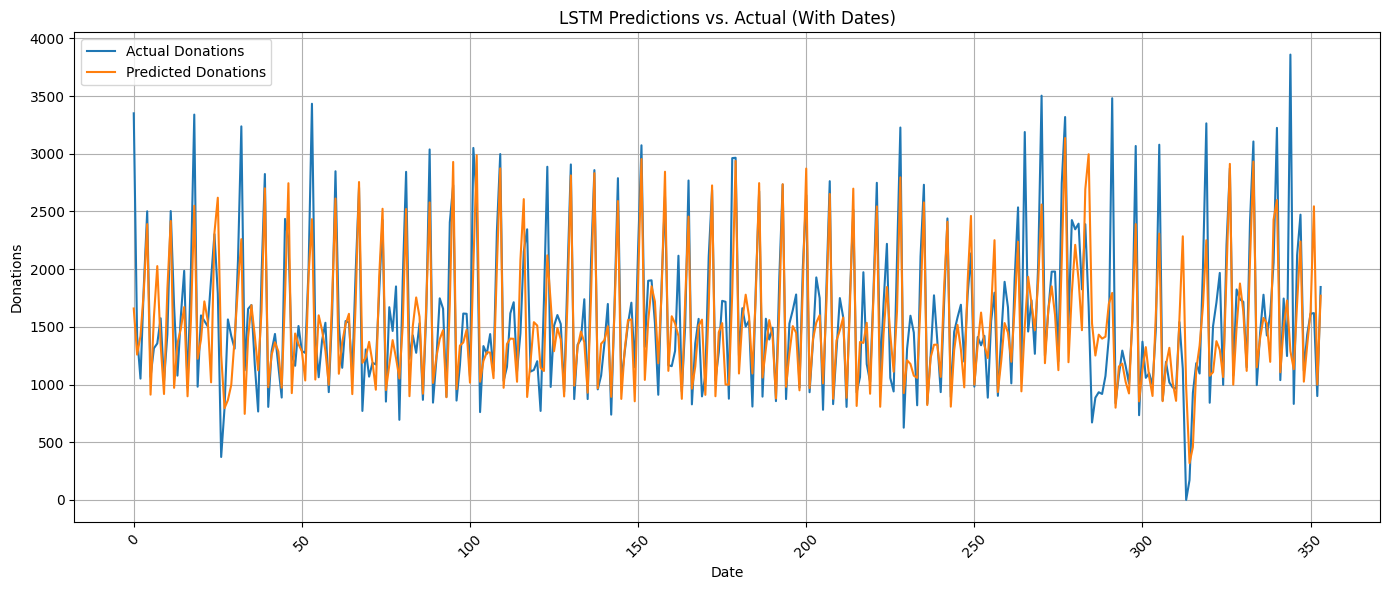

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Donations')
plt.plot(model.predict(X_test), label='Predicted Donations')
plt.title("LSTM Predictions vs. Actual (With Dates)")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

In [16]:
print(mean_absolute_error(y_test, model.predict(X_test)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
274.0712890625


In [17]:
y_test.mean()

np.float64(1608.0112994350281)